In [252]:
import numpy as np
import pandas as pd
import os.path, matplotlib
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
import pickle
import time

In [2]:
def preprocess_data(data, center=True):
    '''
    centers and splits the data for testing and training
    returns x_train, x_test, y_train, y_test
    '''
    label = data.label
    df = data.drop(['label','filename'], axis=1)
    if center:
        scaler = StandardScaler()
        scaler.fit(df)
        df = scaler.transform(df)
    return train_test_split(df, label, test_size=0.5)

In [3]:
def gridsearch(classifier, params, x_train, y_train, name="Test_"):
    '''
    Uses GridSearchCV to tune hyperparameters and saves the GridSearchCV results
    Trains the classifier with the best parameters and scores the model
    '''
    start_time = time.time()
    clf = GridSearchCV(classifier, params, n_jobs=-1, cv=10)
    grid = clf.fit(x_train, y_train)
    print("GridSearchCV elapsed time: {}".format(time.time() - start_time))

    # best_params = grid.best_params_
    # best_score = grid.best_score_
    # print("{}GridSearch \nBest params: {} \nScore: {}".format(name, best_params, best_score))
    
    # Saves GridSearch Result
    filename = "{}GridSearch.sav".format(name)
    pickle.dump(grid, open(filename, 'wb'))
    return grid

In [107]:
def rfc(data, center=True):
    '''
    Uses GridSearchCV to tune hyperparameters for RandomForestClassification
    Saves the grid results to a pickle
    '''
    x_train, x_test, y_train, y_test = preprocess_data(data)
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 5)]
    max_depth = [int(x) for x in np.linspace(start = 10, stop = 500, num = 5)]
    max_features = ['sqrt','log2', None]
    params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    }
    grid = gridsearch(RandomForestClassifier(), params, x_train, y_train, name="RandomForest_")
    return grid, x_train, x_test, y_train, y_test

In [5]:
data = pd.read_csv('data/data.csv')

In [ ]:
rfc_grid = rfc(data)

In [6]:
def non_linear_svm(data, center=True):
    x_train, x_test, y_train, y_test = preprocess_data(data)
    C = np.logspace(-2, 4, 7)
    gamma = np.logspace(-3, 3, 7)
    kernel = ['poly', 'rbf', 'sigmoid']
    params = {
        'C': C,
        'gamma': gamma,
        'kernel': kernel,
    }
    grid = gridsearch(SVC(), params, x_train, y_train, name="NonLinearSVC_")
    return grid, x_train, x_test, y_train, y_test

In [190]:
svm_grid, x_train, x_test, y_train, y_test = non_linear_svm(data)
svm_res = svm_grid.cv_results_

GridSearchCV elapsed time: 6.018208980560303


In [215]:
rfc_grid = pickle.load(open('RandomForest0_GridSearch.sav', 'rb'))
svm_grid = pickle.load(open('NonLinearSVC0_GridSearch.sav', 'rb'))
rfc_res = rfc_grid.cv_results_
svm_res = svm_grid.cv_results_

In [216]:
svm_grid.best_estimator_

SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [217]:
svm_clf = svm_grid.best_estimator_
scores = cross_val_score(svm_clf, x_test, y_test, cv=10)

In [218]:
# 9 degrees of freedome 95% two tailed CI
t = 2.262
mean = np.mean(scores)
se = np.std(scores)/10
ci = [mean - (t*se), mean + (t*se)]

In [219]:
print("95% Confidence Interval: [{}, {}]".format(ci[0], ci[1]))

95% Confidence Interval: [0.6221401696402514, 0.6538598303597484]


In [96]:
np.concatenate((scores, scores))

array([0.58, 0.62, 0.62, 0.64, 0.64, 0.42, 0.76, 0.6 , 0.5 , 0.56, 0.58,
       0.62, 0.62, 0.64, 0.64, 0.42, 0.76, 0.6 , 0.5 , 0.56])

In [100]:
len(scores)

10

In [102]:
def get_ci(scores):
    '''
    19 degrees of freedome 95% two tailed CI
    '''
    t = 2.093
    mean = np.mean(scores)
    se = np.std(scores)/len(scores)
    ci = [mean - (t*se), mean + (t*se)]
    print("95% Confidence Interval: [{}, {}]".format(ci[0], ci[1]))

In [275]:
grid0 = pickle.load(open('RandomForest0_GridSearch.sav', 'rb'))
res0 = grid0.cv_results_
grid1 = pickle.load(open('RandomForest0_GridSearch.sav', 'rb'))
res1 = grid1.cv_results_

In [276]:
print(grid0.best_params_)
print(grid1.best_params_)

{'max_depth': 300, 'max_features': 'sqrt', 'n_estimators': 500}
{'max_depth': 300, 'max_features': 'sqrt', 'n_estimators': 500}


In [183]:
grid0 = pickle.load(open('NonLinearSVC0_GridSearch.sav', 'rb'))
res0 = grid0.cv_results_
grid1 = pickle.load(open('NonLinearSVC1_GridSearch.sav', 'rb'))
res1 = grid1.cv_results_

In [227]:
res0.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [230]:
res0['params']

[{'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 100},
 {'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 200},
 {'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 300},
 {'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 400},
 {'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 500},
 {'max_depth': 100, 'max_features': 'log2', 'n_estimators': 100},
 {'max_depth': 100, 'max_features': 'log2', 'n_estimators': 200},
 {'max_depth': 100, 'max_features': 'log2', 'n_estimators': 300},
 {'max_depth': 100, 'max_features': 'log2', 'n_estimators': 400},
 {'max_depth': 100, 'max_features': 'log2', 'n_estimators': 500},
 {'max_depth': 100, 'max_features': None, 'n_estimators': 100},
 {'max_depth': 100, 'max_features': None, 'n_estimators': 200},
 {'max_depth': 100, 'max_features': None, 'n_estimators': 300},
 {'max_depth': 100, 'max_features': None, 'n_estimators': 400},
 {'max_depth': 100, 'max_features': None, 'n_estimators': 500},
 {'max_depth': 200, 

In [259]:
# X-axis is max_depth. Y-axis is mean score. Color is max_features setting.
redx = []
redy = []
greenx = []
greeny = []
bluex = []
bluey = []
y = res0['mean_test_score']
x = [param['max_depth'] for param in res0['params']]
i = 0
for param in res0['params']:
    if param['max_features'] == None:
        redx.append(x[i])
        redy.append(y[i])
    if param['max_features'] == 'sqrt':
        greenx.append(x[i])
        greeny.append(y[i])
    if param['max_features'] == 'log2':
        bluex.append(x[i])
        bluey.append(y[i])
    i+=1


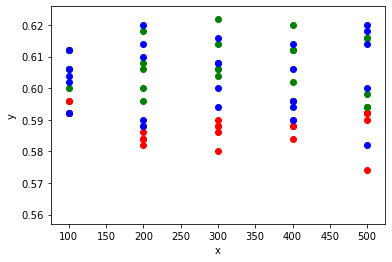

In [274]:
plt.scatter(redx,redy,color='red')
plt.scatter(greenx,greeny,color='green')
plt.scatter(bluex,bluey,color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

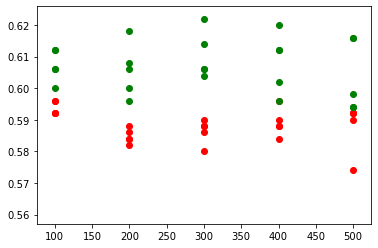

In [265]:
plt.scatter(redx,redy,color='red')
plt.scatter(greenx,greeny,color='green')
plt.show()

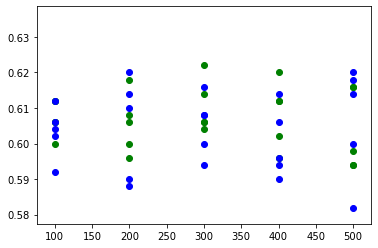

In [267]:
plt.scatter(greenx,greeny,color='green')
plt.scatter(bluex,bluey,color='blue')
plt.show()

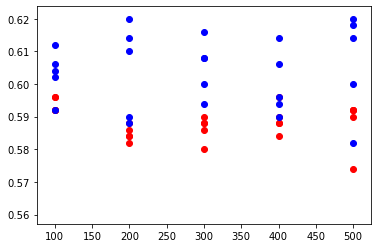

In [263]:
plt.scatter(redx,redy,color='red')
plt.scatter(bluex,bluey,color='blue')
plt.show()